In [70]:
import pandas as pd
import re
import requests
from altair import *
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

Due to requests timing out for the pages repeatedly, I had to manually pull the html for the various recipes.

For the project, I'm taking the first ten filtered recipes returned on `allrecipes.com` when searching for "Mac and Cheese". Prior to selection of the first ten, they were filtered on the basis of serving size--only recipes for 6-8 servings were used.

In [10]:
file_list = ['recipe_0.html', 'recipe_1.html', 'recipe_2.html', 'recipe_3.html', 'recipe_4.html', 'recipe_5.html',
             'recipe_6.html', 'recipe_7.html', 'recipe_8.html', 'recipe_9.html']
soup_list = []

In [12]:
for a_file in file_list:
    soup = BeautifulSoup(open(a_file), "lxml")
    soup_list.append(soup)

In [17]:
# Just a quick test
soup_list[0].find('span', class_='recipe-ingred_txt added').text

'3 cups gemelli pasta, uncooked'

In [19]:
soup_list[0].find('h1', class_='recipe-summary__h1').text

"Ranch Mac 'n Cheese"

In order to normalize measurements, and effectively look at the differences between recipes, everything will be converted to imperial fluid ounces or weight ounces as appropriate. This will require matching common measurement words within recipes. Additionally, if there are no appropraite units of measure matched, it will be assumed to be a discrete number.

In [45]:
measurements = {'cup': 8, 'ounce': 1, 'oz': 1, 'oz.': 1, 'pound': 16, 'pounds': 16, 'Cup': 8, 'Ounce': 1, 'Oz': 1,
                'Oz.': 1, 'Pound': 16, 'Pounds': 16, 'tablespoon': .5, 'Tablespoon': .5, 'tablespoons': .5, 'ounces': 1,
                'Tablespoons': .5, 'tbsp': .5, 'Tbsp': .5, 'TBSP': .5, 'teaspoon': .17, 'Teaspoon': .17, 'Ounces': 1,
                'teaspoons': .17, 'Teaspoons': .17, 'tsp': .17, 'Tsp': .17, 'TSP': .17, 'cups': 8, 'Cups': 8}

At this point, we're just doing a quick and dirty extraction of data, in order to get it into a dataframe and make things easier to deal with; to that effect, the name of the recipe will be pulled, and matche with ingredient text entries. This will get turned into a pivot table and cleaned up later.

In [25]:
data = {'recipe_name': [], 'raw_text': []}
for soup in soup_list:
    rec_name = soup.find('h1', class_='recipe-summary__h1').text
    text_list = soup.find_all('span', class_='recipe-ingred_txt added')
    for item in text_list:
        data['recipe_name'].append(rec_name)
        data['raw_text'].append(re.sub('\(.*\)', '', item.text))
df = pd.DataFrame(data)

In [27]:
df.head()

,raw_text,recipe_name
0,"3 cups gemelli pasta, uncooked",Ranch Mac 'n Cheese
1,1 can evaporated milk,Ranch Mac 'n Cheese
2,1 cup Hidden Valley® Original Ranch® Salad Dre...,Ranch Mac 'n Cheese
3,"2 eggs, slightly beaten",Ranch Mac 'n Cheese
4,3 cups grated Asiago cheese,Ranch Mac 'n Cheese


These functions serve to extract the actually useful information from the ingredient text, as well as normalize the amount of the ingredient that's listed.

In [46]:
def extract_amount(row):
    def ex_am(text):
        words = text.split()
        if re.match('[1234567890]+', words[0]):
            val = eval(words[0])
        else:
            val = 0
        if words[1] in measurements:
            val *= measurements[words[1]]
        return val
    return ex_am(row.raw_text)

In [47]:
def extract_ing(row):
    def ex_ing(text):
        words = text.split()
        if not re.match('[1234567890]+', words[0]):
            return text
        elif words[1] in measurements:
            return " ".join(words[2:])
        else:
            return " ".join(words[1:])
    return ex_ing(row.raw_text)

In [48]:
df['ingredient'] = df.apply(extract_ing, axis=1)

In [49]:
df['amount'] = df.apply(extract_amount, axis=1)

In [56]:
df.head()

,raw_text,recipe_name,ingredient,amount
0,"3 cups gemelli pasta, uncooked",Ranch Mac 'n Cheese,"gemelli pasta, uncooked",24.0
1,1 can evaporated milk,Ranch Mac 'n Cheese,can evaporated milk,1.0
2,1 cup Hidden Valley® Original Ranch® Salad Dre...,Ranch Mac 'n Cheese,Hidden Valley® Original Ranch® Salad Dressing,8.0
3,"2 eggs, slightly beaten",Ranch Mac 'n Cheese,"eggs, slightly beaten",2.0
4,3 cups grated Asiago cheese,Ranch Mac 'n Cheese,grated Asiago cheese,24.0


In [53]:
recipe_details = pd.pivot_table(df, values='amount', index='recipe_name', columns='ingredient')

In [57]:
recipe_details = recipe_details.fillna(0)

In [60]:
recipe_details.head()

ingredient,"1/2 cups sauerkraut, drained",Hidden Valley® Original Ranch® Salad Dressing,all-purpose flour,blue cheese crumbles,butter,"butter, melted",can Campbell's® Condensed Creamy Poblano & Queso Soup,can condensed Cheddar cheese soup,can evaporated milk,chicken stock,...,skim milk,"sleeve buttery round crackers , crushed","slices bread, crusts removed and cubed","slices rye bread, torn","small onion, diced",spicy brown mustard,uncooked elbow macaroni,unsalted butter,unseasoned bread crumbs,water
recipe_name,,,,,,,,,,,,,,,,,,,,,
Buffalo Chicken Mac and Cheese,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Creamy Poblano Mac & Cheese,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Green Mac and Cheese,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mac and Cheese Henwood Style,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mom's Favorite Baked Mac and Cheese,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


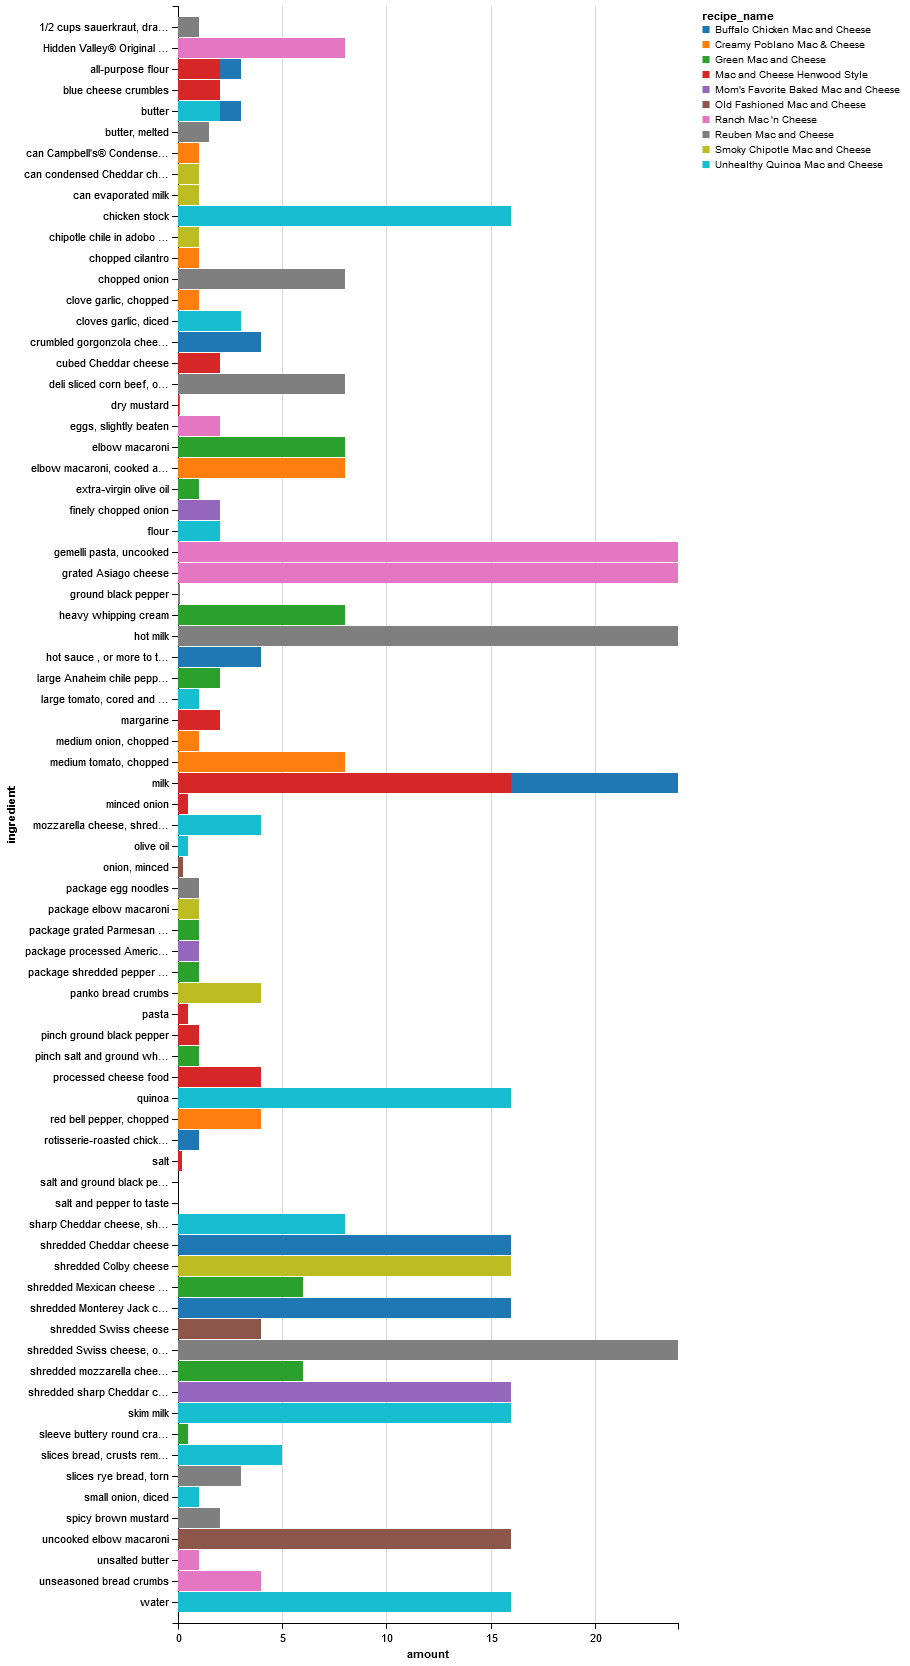

In [72]:
Chart(df).mark_bar().encode(
    color='recipe_name',
    x='amount',
    y='ingredient'
)

Looking at this chart of the amount of various ingredients, I'm rather astounded at how little overlap between recipes there is. I would have expected there to be quite a bit of overlap between recipes, especially since mac and cheese is one of those things that has a basic set of ingredients that should be required in everything; at the very least, flour and fat to make a roux, and pasta.

I think this surprising distribution is probably a function of how ingredients were named in the recipes themselves. Lots of very similar ingredients that could be lumped together, e.g. butter and melted butter, various types of past, and various types of milk, are all considered distinct. The addition of further filtering, most likely with regular expression could furthe improve what information is offered.

Alternately, one could look at this graphic as evidence of the many possible permutations of even a fairly simple recipe.